# Subgroup B Question 3

Addressing Subgroup B Question 3: Resource Allocation for demand variability


*   Simulate guest flow using agent-based modeling and mobilise more staff accordingly to meet the needs of the visitors


## Overview of the Simulation Process:

* Agents involved are Visitors and Staff, which are split into ride operating staff, food stall staff, souvenir shop staff, cleaning staff, security staff.

* The environment of the model is the Universal Studios Singapore(USS) map.

The simulation flow is as such:
* Visitors enter the park when USS opens, choose to visit attractions and queue before getting on their rides or choose to visit souvenir shops to browse the merchandise and eat at food stalls when hungry.
Rides have capacities and wait times.

* When there are long wait times for attractions, more dynamic ride operating staff will be mobilised to the attraction.

* When there are many visitors in souvenir shops or food stalls, more dynamic staff will be mobilised as well to better cater to the needs of the visitors.

* When there are many visitors within a zone, more dynamic cleaning and security staff will be mobilised to the areas as well to better maintain cleanliness and safety of visitors.

* Visitors leave the park as USS approach closing time.

## Running the simulation
The simulation is run in the order of code chunks and if there are changes to various aspects of USS like the size, types of rides, their capacity et cetera, changes can be made to the *Features of USS in Model* code chunk accordingly in their respective dictionaries. To change the number of visitors, input a different number under num_visitors to the Themepark class code chunk in the line:
 > def _ _init__(self, width=50, height=50, num_visitors= 9000):


## Interpreting the output
The simulation outputs a map of USS with the visitor movements in 30minutes intervals and a heatmap overlaying it for ease of visualising the high visitor concentration areas. A staffing recommendation is also printed alongside the map to advice the changes in staffing allocation in response to changes in visitor volumes at the various loactions throughout the day.

# Loading & installing libraries

Installation instructions: This is the list of required instalation versions and libraries that will be used to run the Agent Based Model(ABM) simulation

In [ ]:
!pip install mesa==1.2.1
!pip install matplotlib
!pip install adjustText

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import datetime
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import heapq
from collections import deque
from matplotlib.patches import Wedge, Circle
from adjustText import adjust_text
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from collections import defaultdict
import pandas as pd
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00


# Loading Dataset
Historical wait time dataset on the attractions in USS is used to obtain the popularity weights of the attractions that will influence visitor decisions in visiting a certain attraction.

Utilising wait time data we have obtained to determine the popularity weights to assign attractions. Function ranks the total visitor count for rides in a ascending order as rides with greater visitor counts are more popular and should have greater popularity weights.

In [ ]:
df = pd.read_csv("/waittime_cleandata_updated.csv")
# function to calculate popularity weights of rides:
def calculate_popularity(df):
  ride_popularity_rank = df.groupby("Ride_name")["Visitor_count"].sum().rank(method='dense', ascending=True)
  return {
        "Ride_Popularity_Weights": ride_popularity_rank
    }
ride_popularity = calculate_popularity(df)

### Features of USS in Model:

We are modelling the 20ha Universal Studios Singapore(USS) with a circular map that has a radius of 20 grids that is split into its respective zones and populated by the attractions, souvenir shops and food stalls. The baseline staff roster is also created and more staff will be added should there be an increase in demand, caused by increased visitor concentrations.


There were certain assumptions to be made due to insufficient data about the newest zone in USS. The following assumption was made to help with modeling.

The attractions in the newest zone(Minion Land) will follow a similar trend in popularity when compared to rides of the same type in USS. Minion mayhem is a motion simulator ride - like sesame street spaghetti chase. Swirly Swirly and boogie buggie are carousell rides like accelorator, thus having similar popularity weights.


In [ ]:
# Constants for the park
PARK_CENTER = (25, 25)
PARK_RADIUS = 20
WATER_RADIUS = 4  # The central water body
TIME_STEPS = 21  # 10 AM to 8 PM in 30-min intervals

# Define USS zones with angles and colors
uss_zones = {
    "Hollywood": {"angle_range": (265, 290), "color": "purple"},
    "Minion Land": {"angle_range": (290, 360), "color": "yellow"},
    "Far Far Away": {"angle_range": (0, 65), "color": "grey"},
    "The Lost World": {"angle_range": (65, 130), "color": "green"},
    "Ancient Egypt": {"angle_range": (130, 170), "color": "brown"},
    "Sci-Fi City": {"angle_range": (170, 205), "color": "blue"},
    "New York": {"angle_range": (205, 265), "color": "red"}
}

# Fixed locations for attractions
attractions = {
    "Hollywood": [(28, 18, "Pantages Theater"), (26, 19, "Mel's Mixtape"), (26,5,"Entrance")],
    "Minion Land": [(40, 24, "Minion Mayhem"), (35, 24, "Silly Swirly"), (34,23,"Buggie Boogie")],
    "Far Far Away": [(38, 29, "Shrek 4D"), (33, 39, "Puss in Boots"),(37,39,"Donkey LIVE"),(38,32,"Magic Potion Spin"),(34,27,"Enchanted Airways")],
    "The Lost World": [(16, 37, "Jurassic Rapids"), (26, 38, "Canopy Flyer"), (27, 39,"Dino-Soarin"), (30,38,"Water World")],
    "Ancient Egypt": [(13, 32, "Revenge of Mummy"), (17, 32, "Treasure Hunters")],
    "Sci-Fi City": [(11, 20, "Transformers"), (12, 24, "Cylon"), (10, 25, "Human"), (11, 23, "Accelerator")],
    "New York": [(22, 16, "Sesame Street Spaghetti Chase"), (23, 17, "Rhythm Truck"), (22, 17, "Lights Camera Action!")],
}
# Fixed locations for food stalls
food_stalls = {
    "Hollywood": [(29, 15, "Mel's Drive-In")],
    "Minion Land": [(38, 20, "Pop-A-Nana")],
    "Far Far Away": [(36, 27, "Goldilocks")],
    "The Lost World": [(28, 35, "Discovery Food Court")],
    "Ancient Egypt": [(15, 30, "Oasis Cafe")],
    "Sci-Fi City": [(12.5, 20, "StarBot Cafe")],
    "New York": [(20, 10, "Louie's NY Pizza")],
}

# Fixed locations for souvenir shops
souvenir_shops = {
    "Hollywood": [(25,14,"Candylicious"),(27,6,"Hello Kitty Studio Store"), (28,6,"Minion Mart"),(29,6,"Universal Studios Store"),(25,15,"UNIVRS")],
    "Minion Land": [(37,19,"Sweet Surrender"),(39,23,"Pop Store"), (34,22,"Fun Store")],
    "Far Far Away": [(35,26,"Fairy Godmother's Potion Shop")],
    "The Lost World": [(27,34,"The Dino-Store")],
    "Ancient Egypt": [(16,31,"Carter's Curiosities")],
    "Sci-Fi City": [(12,21,"Transformers shop")],
    "New York":[(21,9,"Big Bird's Emporium")]
}

# Popularity weights for attractions (Higher values mean more popular-based off of wait time predictions)
attraction_weights = {
    "Hollywood": {"Pantages Theater": 5, "Mel's Mixtape": 4, "Entrance": 0},
    "Minion Land": {"Minion Mayhem": 3, "Silly Swirly": 2, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 9, "Puss in Boots": 12, "Donkey LIVE": 3, "Magic Potion Spin": 1, "Enchanted Airways": 5},
    "The Lost World": {"Jurassic Rapids": 11, "Canopy Flyer": 8, "Dino-Soarin": 6, "Water World": 5},
    "Ancient Egypt": {"Revenge of Mummy": 10, "Treasure Hunters": 7},
    "Sci-Fi City": {"Transformers": 14, "Cylon": 13, "Human": 15, "Accelerator": 2},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 2, "Lights Camera Action!": 4},
}

# Define ride capacities (max visitors per cycle) and operation times (steps per cycle)
ride_properties = {
    "Hollywood": {"Pantages Theater": {"capacity": 30, "duration": 3}, "Mel's Mixtape": {"capacity": 20, "duration": 2}, "Entrance": {"capacity": 50, "duration": 1}},
    "Minion Land": {"Minion Mayhem": {"capacity": 40, "duration": 5}, "Silly Swirly": {"capacity": 15, "duration": 3}, "Buggie Boogie": {"capacity": 10, "duration": 2}},
    "Far Far Away": {"Shrek 4D": {"capacity": 50, "duration": 6}, "Puss in Boots": {"capacity": 25, "duration": 4}, "Donkey LIVE": {"capacity": 30, "duration": 3},
                     "Magic Potion Spin": {"capacity": 15, "duration": 2}, "Enchanted Airways": {"capacity": 20, "duration": 4}},
    "The Lost World": {"Jurassic Rapids": {"capacity": 30, "duration": 5}, "Canopy Flyer": {"capacity": 20, "duration": 3}, "Dino-Soarin": {"capacity": 15, "duration": 2},
                       "Water World": {"capacity": 60, "duration": 8}},
    "Ancient Egypt": {"Revenge of Mummy": {"capacity": 25, "duration": 4}, "Treasure Hunters": {"capacity": 10, "duration": 2}},
    "Sci-Fi City": {"Transformers": {"capacity": 40, "duration": 5}, "Cylon": {"capacity": 30, "duration": 4}, "Human": {"capacity": 30, "duration": 4},
                    "Accelerator": {"capacity": 15, "duration": 2}},
    "New York": {"Sesame Street Spaghetti Chase": {"capacity": 20, "duration": 3}, "Rhythm Truck": {"capacity": 10, "duration": 2}, "Lights Camera Action!": {"capacity": 25, "duration": 4}},
}

# Baseline staffing of ride operators when there is no crowd
Ride_operators_record ={
    "Hollywood": {"Pantages Theater": 3, "Mel's Mixtape": 3, "Entrance": 2},
    "Minion Land": {"Minion Mayhem": 3, "Silly Swirly": 3, "Buggie Boogie": 3},
    "Far Far Away": {"Shrek 4D": 3, "Puss in Boots": 3, "Donkey LIVE": 3, "Magic Potion Spin": 3, "Enchanted Airways": 3},
    "The Lost World": {"Jurassic Rapids": 3, "Canopy Flyer": 3, "Dino-Soarin": 3, "Water World": 3},
    "Ancient Egypt": {"Revenge of Mummy": 3, "Treasure Hunters": 3},
    "Sci-Fi City": {"Transformers": 3, "Cylon": 3, "Human": 3, "Accelerator": 3},
    "New York": {"Sesame Street Spaghetti Chase": 3, "Rhythm Truck": 3, "Lights Camera Action!": 3},
}

# Baseline staffing of cleaning staff when there is no crowd
Cleaning_staff_record ={
    "Hollywood": 1,
    "Minion Land": 1,
    "Far Far Away": 1,
    "The Lost World": 1,
    "Ancient Egypt": 1,
    "Sci-Fi City": 1,
    "New York": 1,
}

# Baseline staffing of security staff when there is no crowd
Security_staff_record ={
    "Hollywood": 1,
    "Minion Land": 1,
    "Far Far Away": 1,
    "The Lost World": 1,
    "Ancient Egypt": 1,
    "Sci-Fi City": 1,
    "New York": 1,
}

# Baseline staffing of food stalls when there is no crowd
Food_stall_staff_record ={
    "Hollywood": {"Mel's Drive-In":1},
    "Minion Land": {"Pop-A-Nana":1},
    "Far Far Away": {"Goldilocks":1},
    "The Lost World": {"Discovery Food Court":1},
    "Ancient Egypt": {"Oasis Cafe":1},
    "Sci-Fi City": {"StarBot Cafe":1},
    "New York": {"Louie's NY Pizza":1},
}

# Baseline staffing of souvenir shops when there is no crowd
Souvenir_shop_staff_record ={
    "Hollywood": {"Candylicious":1,"Hello Kitty Studio Store":1, "Minion Mart":1,"Universal Studios Store":1,"UNIVRS":1},
    "Minion Land": {"Sweet Surrender":1,"Pop Store":1, "Fun Store":1},
    "Far Far Away": {"Fairy Godmother's Potion Shop":1},
    "The Lost World": {"The Dino-Store":1},
    "Ancient Egypt": {"Carter's Curiosities":1},
    "Sci-Fi City": {"Transformers shop":1},
    "New York": {"Big Bird's Emporium":1},
}

### Adjust the Duration of rides to accommodate for buffer for rides, explained in subgroup B question 2

def adjust_duration(data, duration_change):
  for zone, rides in data.items():
    for ride, details in rides.items():
      duration = details["duration"]

      details["duration"] = int(duration + duration_change)

  return data

# adjust such that to account for 7 minute buffer
ride_properties = adjust_duration(ride_properties, 7)

ride_properties

{'Hollywood': {'Pantages Theater': {'capacity': 30, 'duration': 10},
  "Mel's Mixtape": {'capacity': 20, 'duration': 9},
  'Entrance': {'capacity': 50, 'duration': 8}},
 'Minion Land': {'Minion Mayhem': {'capacity': 40, 'duration': 12},
  'Silly Swirly': {'capacity': 15, 'duration': 10},
  'Buggie Boogie': {'capacity': 10, 'duration': 9}},
 'Far Far Away': {'Shrek 4D': {'capacity': 50, 'duration': 13},
  'Puss in Boots': {'capacity': 25, 'duration': 11},
  'Donkey LIVE': {'capacity': 30, 'duration': 10},
  'Magic Potion Spin': {'capacity': 15, 'duration': 9},
  'Enchanted Airways': {'capacity': 20, 'duration': 11}},
 'The Lost World': {'Jurassic Rapids': {'capacity': 30, 'duration': 12},
  'Canopy Flyer': {'capacity': 20, 'duration': 10},
  'Dino-Soarin': {'capacity': 15, 'duration': 9},
  'Water World': {'capacity': 60, 'duration': 15}},
 'Ancient Egypt': {'Revenge of Mummy': {'capacity': 25, 'duration': 11},
  'Treasure Hunters': {'capacity': 10, 'duration': 9}},
 'Sci-Fi City': {'Tr

### Visitor class

They are allowed to move around within the map and take actions like ride an attraction, eat and browse souvenir shops.

There were certain assumptions to be made due to lack of data about souvenir shops and food stalls visitors. We have assumed the following to help us with the modeling:

1. Visitors are more likely to visit food stalls or souvenir shops within the zone they are in at any given time as opposed to going to one that is further away in another zone.


In [ ]:
class Visitor(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.time_in_park = 0   #Attribute keeping track of how long visitor has been in the themepark.
        self.destination = None   # Attribute keeping track of destination of visitor
        self.riding_time = 0   # Attribute keeping track of how long the visitor has been riding rides
        self.current_zone = None   # Attribute keeping track of the visitor's current zone
        self.hunger = 0   # Attribute keeping track of hunger levels of a visitor and increases throughout the day until visitor eats
        self.eating_time = 0   # Attribute keeping track of how long a visitor has been eating
        self.last_ride = None   #Attribute keeping track of last ride visitor has taken
        self.browsing = 0   # Attribute keeping track of how long a visitor has been browsing souvenir shops
        self.shop_prob = 0.05  # Attribute storing the probability of a visitor visiting a souvenir shop
        self.eat_count = 0  # Attribute storing number of times the visitor has eaten
        self.exponential = 2

    def step(self):
      self.time_in_park += 1

      if self.riding_time > 0:  # if visitor is on a ride from previous step, finish the ride
          self.riding_time = 0
          return

      if self.browsing > 0:  # if visitor is browsing souvenir shops from previous step, finish browsing
          self.browsing -= 1
          self.destination = None
          return

      # Increase hunger over time
      if self.eating_time == 0 and self.eat_count == 0:
          self.hunger += 1

      if self.eating_time == 0 and self.eat_count == 1:  # if visitor has already eaten once in the ethemepark, their hunger levels increase more slowly
          self.hunger += 0.5

      if self.hunger >= 5 and self.riding_time == 0:  # if visitor has hunger level >= 5, they are hungry and make them go to the nearest food stall if they are not currently on a ride
        food = self.find_nearest_food()  #(zone, stall_name)
        if food:
            self.destination = food
            self.move_towards(food)

      if self.eating_time > 0:  # if visitor is eating, reduce eating time
          self.eating_time -= 1
          if self.eating_time == 0:  # when visitor finished eating, decrease hunger levels to 0 and update eating count
            self.hunger = 0
            self.eat_count += 1
            self.destination = None
            return

      # Goes shopping with probability of shopping probability assigned, else attractions when not hungry
      if not self.destination:
        if random.random() <= self.shop_prob:
          self.destination = self.choose_shop()
        else:
          self.destination = self.choose_attraction()

      self.move_towards(self.destination)

    def choose_shop(self):
      """Finds the nearest shop based on visitor's current position."""
      min_distance = float("inf")
      closest_shop = None

      for zone, shops in souvenir_shops.items():
          for (x, y, shop_name) in shops:
              path = self.model.get_shortest_path(self.pos, (x, y))
              dist = len(path)
              if dist < min_distance:
                  min_distance = dist
                  closest_shop = (zone, shop_name)
      return closest_shop

    def find_nearest_food(self):
      """Finds the nearest food stall based on visitor's current position."""
      current_zone = self.current_zone
      if current_zone is None:
          current_zone = self.get_zone_from_position(self.pos)
      closest_food = (current_zone, food_stalls[current_zone][0][2])
      return closest_food

    def start_eating(self):
        """Starts the eating process for the visitor."""
        self.eating_time = 1
        self.hunger = 0

    def start_browsing(self):
        """Starts the browsing process for the visitor."""
        self.browsing = 1

    def choose_attraction(self):
      """Selects an attraction based on popularity weights."""
      # Calculate total popularity for each zone
      zone_popularity = {zone: sum(attraction_weights[zone].values()) for zone in attraction_weights}

      # Create lists of zones and their corresponding popularity weights
      all_zones = list(zone_popularity.keys())
      weights = [zone_popularity[zone] ** self.exponential for zone in all_zones]

      # Select a zone based on the calculated weights
      chosen_zone = random.choices(all_zones, weights=weights, k=1)[0]

      # Get the list of rides and their weights for the chosen zone
      rides = list(attraction_weights[chosen_zone].keys())
      ride_weights = [attraction_weights[chosen_zone][ride] ** self.exponential for ride in rides]
      # Normalize the ride weights
      total_weight = sum(ride_weights)
      normalized_weights = [w / total_weight for w in ride_weights]

      # Remove the last ride if it exists
      if self.last_ride in rides and len(rides) > 1:
          last_ride_index = rides.index(self.last_ride)
          rides.remove(self.last_ride)
          normalized_weights.pop(last_ride_index)  # Remove the corresponding weight

      # Choose a ride based on the normalized weights
      chosen_ride = random.choices(rides, weights=normalized_weights, k=1)[0]

      return chosen_zone, chosen_ride


    def get_zone_from_position(self, pos):
      """Determines which USS zone a given position belongs to."""
      x, y = pos
      dx, dy = x - PARK_CENTER[0], y - PARK_CENTER[1]  # Get relative position from center
      if dx == 0 and dy == 0:
          return None

      angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360  # Compute angle and normalize

      for zone, data in uss_zones.items():
          start_angle, end_angle = data["angle_range"]
          if start_angle <= angle < end_angle:
              return zone  # Return the corresponding zone
      return None

    def move_towards(self, destination):
      """Moves the visitor towards the destination, which could be a ride, food stall, or souvenir shop."""
      zone, name = destination

      # Initialize default values for destination types and coordinates
      target_x, target_y = None, None
      food_stall_found = False
      souvenir_shop_found = False
      ride_found = False

      # First, check if it's a food stall
      if zone in food_stalls:
          for x, y, stall_name in food_stalls[zone]:
              if stall_name == name:
                  food_stall_found = True
                  target_x, target_y = x, y
                  break

      # Then, check if it's a souvenir shop
      if not food_stall_found and zone in souvenir_shops:
          for x, y, shop_name in souvenir_shops[zone]:
              if shop_name == name:
                  souvenir_shop_found = True
                  target_x, target_y = x, y
                  break

      # If neither food stall nor souvenir shop, treat it as an attraction
      if not (food_stall_found or souvenir_shop_found) and zone in attractions:
          for x, y, attraction_name in attractions[zone]:
              if attraction_name == name:
                  ride_found = True
                  target_x, target_y = x, y
                  break

      # Introduce slight randomness in the final target position (±1 in x or y) due to plotting constraints
      target_x += random.choice([-1, 0, 1])
      target_y += random.choice([-1, 0, 1])

      dest_pos = (target_x, target_y)
      if (abs(self.pos[0] - target_x) <= 2) and (abs(self.pos[1] - target_y) <= 2):
        # Visitor is close enough, so handle the post-arrival actions
        if ride_found:  # if destination is an attraction, make visitor queue or take ride
            self.enter_ride(zone, name)
        elif food_stall_found:  # if destination is a food stall, make visitor start eating
            self.start_eating()
        elif souvenir_shop_found:  #if destination is a souvenir shop, make visitor satrt browsing
            self.start_browsing()
      else:
          # Visitor is not at the target yet, so move towards it
          if self.pos != dest_pos:
              path = self.model.get_shortest_path(self.pos, dest_pos)
              if path:
                  self.model.grid.move_agent(self, path[min(10, len(path)-1)])
              if not path:  # If no valid path, pick another destination
                  self.destination = self.choose_attraction()
                  return

    def enter_ride(self, zone, ride):
        """Handles queueing and entering rides."""
        ride_data = self.model.ride_active[zone][ride]
        ride_queue = self.model.ride_queues[zone][ride]
        ride_capacity = ride_properties[zone][ride]["capacity"]

        if ride_data["occupied"] >= ride_capacity or ride_data["timer"] > 0:  # if ride is completely full or ride is currently operating with other visitors, make visitor join queue
            ride_queue.append(self)
        else:
            ride_data["occupied"] += 1  # else, add visitor onto ride and start the ride
            self.riding_time = ride_properties[zone][ride]["duration"]

### Staff class
There are baseline staff that are allocated to their respective zones and tasks as ride operators, food stall staff, souvenir shop staff, cleaning staff and security staff and also dynamic staff to be added simultaneously to the baseline staff throughout the simulation when necessary.

In [ ]:
class Staff(Agent):
    def __init__(self, unique_id, model, stationed_at=None, dynamic=False, ride = None, food = None, shop = None):
        super().__init__(unique_id, model)
        self.stationed_at = stationed_at  # Fixed location
        self.dynamic = dynamic  # True if it's a dynamically assigned staff
        self.ride = ride  # if staff is ride operating staff, attribute will be the attraction they are stationed at, else would be None
        self.food = food  # if staff is food stall staff, attribute will be the food stall they are stationed at, else would be None
        self.shop = shop  # if staff is souvenir shop staff, attribute will be the souvenir shop they are stationed at, else would be None

        # Fixed staff stay at their assigned positions
        if self.stationed_at:
            self.pos = self.stationed_at
        else:
            self.pos = model.random_position()

    def step(self):
        if self.stationed_at:
            return  # Fixed staff do not move

# Themepark class

Rationale for 900 visitors, an average of the total annumal visitors, is mentioned in Subgroup B question 2.

In [ ]:
class ThemePark(Model):
    def __init__(self, width=50, height=50, num_visitors= 9000):

        self.grid = MultiGrid(width, height, torus=False)  # dimensions of themepark plot
        self.schedule = SimultaneousActivation(self)
        self.zone_population = {zone: 0 for zone in uss_zones}  # Attribute keeping track of the visitor counts in each zone
        self.dynamic_staff = []  # Track dynamically added staff
        self.start_time = datetime.datetime(2025, 1, 1, 10, 0)  # Start at 10:00 AM
        self.time_per_step = datetime.timedelta(minutes=30)  # Attribute for the duration of each step of simulation

        # queue states of rides
        self.ride_queues = {zone: {ride: deque() for ride in rides} for zone, rides in ride_properties.items()}
        self.ride_active = {zone: {ride: {"occupied": 0, "timer": 0} for ride in rides} for zone, rides in ride_properties.items()}

        # Visitor entrance scheduling
        self.total_visitors = num_visitors
        self.remaining_visitors = num_visitors
        self.entrance_queue = list(range(num_visitors))  # List of visitor IDs to enter

        # dictionaries keeping track of dynamic staffs added to the respective jobs
        self.staff_by_shop = defaultdict(list)
        self.staff_by_food = defaultdict(list)
        self.staff_by_ride = defaultdict(list)
        self.staff_by_sec = defaultdict(list)
        self.staff_by_clean = defaultdict(list)

        # dictionary keeping track of the queue lengths of each ride
        self.queue_lengths = {}

        # Shuffle for randomness in entry order
        random.shuffle(self.entrance_queue)

        last_staff_id = num_visitors

        # Assign three staff to each attraction
        for zone, locations in attractions.items():
            for location in locations:
                for _ in range(3):  # Assign 3 staff members per attraction
                    position = (int(location[0]), int(location[1]))   # Get (x, y) coordinates
                    staff = Staff(last_staff_id, self, stationed_at=position, ride = location)
                    self.grid.place_agent(staff, position)
                    self.schedule.add(staff)
                    last_staff_id += 1

        # Assign one staff to each souvenir shop
        for zone, locations in souvenir_shops.items():
            for location in locations:
                position = (int(location[0]), int(location[1]))
                staff = Staff(last_staff_id, self, stationed_at=position, shop = location)
                self.grid.place_agent(staff, position)
                self.schedule.add(staff)
                last_staff_id += 1

        # Assign one staff to each food stall
        for zone, locations in food_stalls.items():
            for location in locations:
                position = (int(location[0]), int(location[1]))
                staff = Staff(last_staff_id, self, stationed_at=position, food = location)
                self.grid.place_agent(staff, position)
                self.schedule.add(staff)
                last_staff_id += 1

        # Assign one clening staff to each zone
        for zone in attractions.keys():
            position = (int(location[0]), int(location[1]))
            staff = Staff(last_staff_id, self, stationed_at=position)
            self.grid.place_agent(staff, position)
            self.schedule.add(staff)
            last_staff_id += 1

        #Assign one security to each zone
        for zone in attractions.keys():
            position = (int(location[0]), int(location[1]))
            staff = Staff(last_staff_id, self, stationed_at=position)
            self.grid.place_agent(staff, position)
            self.schedule.add(staff)
            last_staff_id += 1


    def calculate_wait_time(self, zone, ride):
      """Calculates the wait time for a ride."""
      ride_data = self.ride_active[zone][ride]
      ride_queue = self.ride_queues[zone][ride]
      ride_duration = ride_properties[zone][ride]["duration"]
      ride_capacity = ride_properties[zone][ride]["capacity"] * int(30/ride_duration) # Take into account each simulation step is 30min
      # Assuming each visitor spends the ride duration on a ride
      visitors_in_queue = len(ride_queue)
      wait_time = (visitors_in_queue / ride_capacity) # In terms of 30min steps
      return wait_time

    def update_queue_lengths(self):
      """Updates the queue lengths for each ride."""
      for zone, rides in self.ride_queues.items():
          for ride_name, queue in rides.items():
              self.queue_lengths[(zone, ride_name)] = len(queue)

    def get_zone_from_position(self, pos):
      """Determines which USS zone a given position belongs to."""
      x, y = pos
      dx, dy = x - PARK_CENTER[0], y - PARK_CENTER[1]  # Get relative position from center
      if dx == 0 and dy == 0:
          return None

      angle = (math.degrees(math.atan2(dy, dx)) + 360) % 360  # Compute angle and normalize

      for zone, data in uss_zones.items():
          start_angle, end_angle = data["angle_range"]
          if start_angle <= angle < end_angle:
              return zone  # Return the corresponding zone name
      return None

    def update_zone_population(self):
      """Counts the number of visitors in each USS zone."""
      self.zone_population = {zone: 0 for zone in uss_zones}  # Reset visitor count

      for agent in self.schedule.agents:
          if isinstance(agent, Visitor) and agent.get_zone_from_position(agent.pos):
              self.zone_population[agent.get_zone_from_position(agent.pos)] += 1

    def get_shortest_path(self, start, goal):
        """Uses A* algorithm to find the shortest path from start to goal."""
        open_set = []
        heapq.heappush(open_set, (0, start))  # (priority, node)

        came_from = {}  # Tracks how we reached each node
        g_score = {start: 0}  # Cost from start to each node
        f_score = {start: self.manhattan_distance(start, goal)}  # Estimated cost (g + h)

        visited = set()
        water_body_threshold = WATER_RADIUS ** 2  # Avoid recalculating square root

        while open_set:
            _, current = heapq.heappop(open_set)  # Node with lowest f-score

            if current == goal:
                return self.reconstruct_path(came_from, current)  # Build path

            if current in visited:
                continue
            visited.add(current)

            for neighbor in self.grid.get_neighborhood(current, moore=True, include_center=False):
                if ((neighbor[0] - PARK_CENTER[0]) ** 2 + (neighbor[1] - PARK_CENTER[1]) ** 2) < water_body_threshold:
                    continue  # Skip water body

                tentative_g_score = g_score[current] + 1  # Assume uniform cost (grid-based)
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.manhattan_distance(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        return []  # No valid path found

    def reconstruct_path(self, came_from, current):
        """Reconstructs the path from goal to start."""
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

    def manhattan_distance(self, a, b):
        """Computes Manhattan distance as a heuristic."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def update_rides(self):
        """Handle ride operation cycles and move visitors from queue to ride."""
        for zone, rides in self.ride_active.items():
            for ride, data in rides.items():
                ride_duration = ride_properties[zone][ride]["duration"]
                ride_capacity = ride_properties[zone][ride]["capacity"] * int(30/ride_duration) # Take into account each simulation step is 30min

                # Check if ride is running
                if data["timer"] > 0:
                    data["timer"] = 0  # Reduce timer
                    if data["timer"] == 0:
                        data["occupied"] = 0  # Ride empties
                else:
                    # Load new visitors if there's space
                    while self.ride_queues[zone][ride] and data["occupied"] < ride_capacity:
                        visitor = self.ride_queues[zone][ride].popleft()
                        data["occupied"] += 1
                        visitor.riding_time = ride_duration  # Set visitor's ride time

                    # Start new ride cycle if visitors are inside
                    if data["occupied"] > 0:
                        data["timer"] = ride_duration

    def manage_cleaning_staff(self):
      # Assign more dynamic cleaning staff to zones accordingly where population > 100
      for zone, count in self.zone_population.items():
        if count > 500:
            required_cleaning_staff = 3
        elif count >= 250:
            required_cleaning_staff = 2
        elif count >= 100:
            required_cleaning_staff = 1
        else:
            required_cleaning_staff = 0
        # Count existing dynamic cleaning staff in the zone
        existing_cleaning_staff = Cleaning_staff_record[zone] - 1
        # Add missing dynamic cleaning staff
        while existing_cleaning_staff < required_cleaning_staff:
            # Compute a central location for dynamic cleaning staff
            zone_positions = attractions.get(zone, []) + food_stalls.get(zone, []) + souvenir_shops.get(zone, [])
            if zone_positions:
                x_coords, y_coords = zip(*[pos[:2] for pos in zone_positions])
                center_x = int(sum(x_coords) // len(x_coords))  # Ensure integer
                center_y = int(sum(y_coords) // len(y_coords))  # Ensure integer
                center_position = (center_x, center_y)

                # Create new dynamic cleaning staff
                new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                new_staff = Staff(new_staff_id, self, stationed_at=zone, dynamic=True)
                self.grid.place_agent(new_staff, center_position)
                self.dynamic_staff.append(new_staff)
                existing_cleaning_staff += 1
                # Update cleaning staff record
                Cleaning_staff_record [zone] += 1
                if zone not in self.staff_by_clean:
                      self.staff_by_clean[zone] = []
                self.staff_by_clean[zone].append(new_staff)

        # Remove extra dynamic cleaning staff if visitors decrease
        while existing_cleaning_staff > required_cleaning_staff:
            staff_list = self.staff_by_clean.get(zone, [])
            if staff_list:
                staff_to_remove = staff_list.pop()
                if staff_to_remove and staff_to_remove.unique_id in self.schedule._agents:
                    self.schedule.remove(staff_to_remove)
                    self.grid.remove_agent(staff_to_remove)
                    self.dynamic_staff.remove(staff_to_remove)
                    existing_cleaning_staff -= 1
                    # Update cleaning staff record
                    Cleaning_staff_record [zone] -= 1
            else:
                break
        if self.zone_population.values() == 0:  # No visitors in zone
          staff_list = self.staff_by_clean.get(zone, [])
          if staff_list:
            for staff in staff_list[:]:
                if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                    self.schedule.remove(staff)
                    self.grid.remove_agent(staff)
                    self.dynamic_staff.remove(staff_to_remove)
          Cleaning_staff_record[zone] = 1  # Reset to baseline cleaning staff


    def manage_security_staff(self):
      # Assign more dynamic security staff accordingly to zones where population > 100
      # 1 to about 100 visitors ratio
      self.update_zone_population()
      for zone, count in self.zone_population.items():
        if count > 600:
            required_security_staff = 5
        elif count >= 350:
            required_security_staff = 3
        elif count >= 200:
            required_security_staff = 2
        elif count >= 100:
            required_security_staff = 1
        else:
            required_security_staff = 0
        # Count existing dynamic security staff in the zone
        existing_security_staff = Security_staff_record[zone] - 1
        # Add missing dynamic security staff
        while existing_security_staff < required_security_staff:
            # Compute a central location for dynamic security staff
            zone_positions = attractions.get(zone, []) + food_stalls.get(zone, []) + souvenir_shops.get(zone, [])
            if zone_positions:
                x_coords, y_coords = zip(*[pos[:2] for pos in zone_positions])
                center_x = int(sum(x_coords) // len(x_coords))  # Ensure integer
                center_y = int(sum(y_coords) // len(y_coords))  # Ensure integer
                center_position = (center_x, center_y)

                # Create new dynamic security staff
                new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                new_staff = Staff(new_staff_id, self, stationed_at=zone, dynamic=True)
                self.grid.place_agent(new_staff, center_position)
                self.dynamic_staff.append(new_staff)
                existing_security_staff += 1
                # Update security staff record
                Security_staff_record[zone] += 1
                if zone not in self.staff_by_sec:
                      self.staff_by_sec[zone] = []
                self.staff_by_sec[zone].append(new_staff)

        # Remove extra dynamic security staff if visitors decrease
        while existing_security_staff > required_security_staff:
            staff_list = self.staff_by_sec.get(zone, [])
            if staff_list:
                staff_to_remove = staff_list.pop()
                if staff_to_remove and staff_to_remove.unique_id in self.schedule._agents:
                      self.schedule.remove(staff_to_remove)
                      self.grid.remove_agent(staff_to_remove)
                      self.dynamic_staff.remove(staff_to_remove)
                      existing_security_staff -= 1
                      # Update security staff record
                      Security_staff_record[zone] -= 1
            else:
                break

        if self.zone_population.values() == 0:  # No visitors in zone
          staff_list = self.staff_by_sec.get(zone, [])
          if staff_list:
            for staff in staff_list[:]:
                if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                    self.schedule.remove(staff)
                    self.grid.remove_agent(staff)
                    self.dynamic_staff.remove(staff)
          Security_staff_record[zone] = 1  # Reset to baseline security staff


    def manage_dynamic_staff(self):
      # Check each ride for wait times and adjust ride operating staff accordingly
      for zone, rides in self.ride_queues.items():
          for ride, queue in rides.items():
              wait_time = self.calculate_wait_time(zone, ride)
              required_staff = 0

              if wait_time >= 2:  #requires more than 1 step to clear queue
                  required_staff = 3
              elif wait_time >= 1:  # requires 1 step to clear queue
                  required_staff = 2  #need 2 more staff
              elif wait_time > 0: # requires 1 step to clear queue
                  required_staff = 1  # need 1 more staff

              # Count how many dynamic staff are already dynamically assigned to this ride
              current_staff_count = Ride_operators_record[zone][ride] - 3

              # Add dynamic staff if needed
              while current_staff_count < required_staff:
                if ride == "Entrance":  # Entrances function differently
                  break
                else:
                  ride_coord = None
                  for ride1 in attractions[zone]:
                    if ride1[2] == ride:  # If the ride name matches
                        ride_coord = (int(ride1[0]), int(ride1[1]))
                        break
                  if ride_coord:
                    new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                    new_staff = Staff(new_staff_id, self, stationed_at=zone, dynamic=True, ride = ride)
                    self.grid.place_agent(new_staff, ride_coord)
                    self.schedule.add(new_staff)
                    self.dynamic_staff.append(new_staff)
                    current_staff_count += 1
                    # Update ride opreator record
                    Ride_operators_record[zone][ride] += 1
                    if (zone, ride) not in self.staff_by_ride:
                        self.staff_by_ride[(zone, ride)] = []
                    self.staff_by_ride[(zone, ride)].append(new_staff)

              # Remove extra dynamic staff if needed
              while current_staff_count > required_staff:
                if ride == "Entrance":  # Entrances function differently
                    break
                else:
                    staff_list = self.staff_by_ride.get((zone, ride), [])
                    if staff_list:
                      staff_to_remove = staff_list.pop()
                      if staff_to_remove and staff_to_remove.unique_id in self.schedule._agents and staff_to_remove.pos is not None:
                        self.schedule.remove(staff_to_remove)
                        self.grid.remove_agent(staff_to_remove)
                        self.dynamic_staff.remove(staff_to_remove)
                        current_staff_count -= 1
                        # Update ride opreator record
                        Ride_operators_record[zone][ride] -= 1

              if ride == "Entrance":  # Entrances function differently
                if self.schedule.time <= 2 or self.schedule.time >= 20:
                  for ride1 in attractions[zone]:
                    if ride1[2] == ride:  # If the ride name matches
                        ride_coord = None
                    for ride1 in attractions[zone]:
                      if ride1[2] == ride:  # If the ride name matches
                          ride_coord = (int(ride1[0]), int(ride1[1]))
                          break

                    if ride_coord and Ride_operators_record[zone][ride] < 4:
                      for _ in range(2):   # Has a total of 4 entrance staff during peak hours when visitors enter
                        new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                        new_staff1 = Staff(new_staff_id, self, stationed_at=zone, dynamic=True, ride = ride)
                        self.grid.place_agent(new_staff1, ride_coord)
                        self.schedule.add(new_staff1)
                        self.dynamic_staff.append(new_staff1)
                        # Update ride opreator record
                        Ride_operators_record[zone][ride] += 1
                        if (zone, ride) not in self.staff_by_ride:
                            self.staff_by_ride[(zone, ride)] = []
                        self.staff_by_ride[(zone, ride)].append(new_staff1)
                else:   # Reverts back to only having 1 entrance staff during off-peak hours
                    staff_list = self.staff_by_ride.get((zone, ride), [])
                    if staff_list:
                        for staff in staff_list[:]:  # Iterate over a copy
                            if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                                  self.schedule.remove(staff)
                                  self.grid.remove_agent(staff)
                                  self.dynamic_staff.remove(staff)
                    Ride_operators_record[zone][ride] = 2


              wait_time = self.calculate_wait_time(zone, ride)
              if wait_time == 0 and ride != "Entrance":  # No visitors in this ride's queue
                   staff_list = self.staff_by_ride.get((zone, ride), [])
                   if staff_list:
                      for staff in staff_list[:]:  # Iterate over a copy
                          if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                                self.schedule.remove(staff)
                                self.grid.remove_agent(staff)
                                self.dynamic_staff.remove(staff)

                   # Reset the staff count to baseline for the specific ride
                   if zone in Ride_operators_record:
                      if ride in Ride_operators_record[zone] and ride != "Entrance":
                        Ride_operators_record[zone][ride] = 3


    def update_shop_food(self):
        """Handle food and souvenir shop operations."""
        food_visitors = {} # Track number of visitors per food stall
        shop_visitors = {}  # Track number of visitors per shop
        required_staff1 = {}  # Track number of required dynamic staff for souvenir shops
        required_staff2 = {}  # Track number of required dynamic staff for food stalls

        # counting number of visitors browsing in each souvenir shop
        for agent in self.schedule.agents:
            if isinstance(agent, Visitor):
              visitor_x, visitor_y = agent.pos
              # Check proximity to shops
              for zone, shops in souvenir_shops.items():
                  for shop in shops:
                      shop_x, shop_y, shop_name = shop
                      if (abs(visitor_x - shop_x) <= 1) and (abs(visitor_y - shop_y) <= 1) and agent.browsing > 0:
                        if zone not in shop_visitors:
                            shop_visitors[zone] = {}
                        if shop_name not in shop_visitors[zone]:
                            shop_visitors[zone][shop_name] = 0
                        shop_visitors[zone][shop_name] += 1

              # counting number of visitors eating in each food stall
              for zone, stalls in food_stalls.items():
                  for stall in stalls:
                      stall_x, stall_y, stall_name = stall
                      if (abs(visitor_x - stall_x) <= 1) and (abs(visitor_y - stall_y) <= 1) and agent.eating_time > 0:
                          # Within 1-cell range AND currently eating
                          if zone not in food_visitors:
                              food_visitors[zone] = {}
                          if stall_name not in food_visitors[zone]:
                              food_visitors[zone][stall_name] = 0
                          food_visitors[zone][stall_name] += 1

        # Adjust dynamic staff allocation based on number of visitors
        for zone, shop_count in shop_visitors.items():
            for shop_name, visitor_count in shop_count.items():
              if shop_name not in required_staff1:
                  required_staff1[shop_name] = 0
              if visitor_count >= 10:
                  required_staff1[shop_name] = 2
              elif visitor_count >= 3:
                  required_staff1[shop_name] = 1
              # Count how many staff are already dynamically assigned to this shop.
              current_dstaff_count = Souvenir_shop_staff_record[zone][shop_name] - 1
              # Add dynamic staff if needed
              while current_dstaff_count < required_staff1[shop_name]:
                  for shop in souvenir_shops[zone]:
                    if shop[2] == shop_name:  # If the shop name matches
                        shop_coord = tuple(map(int, shop[:2]))
                        break
                  if shop_coord is None:
                      continue
                  new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                  new_staff = Staff(new_staff_id, self, stationed_at=zone, dynamic=True, shop = shop_name)
                  self.grid.place_agent(new_staff, shop_coord)
                  self.schedule.add(new_staff)
                  self.dynamic_staff.append(new_staff)
                  current_dstaff_count += 1
                  # Update sovenir shp staffing record
                  Souvenir_shop_staff_record[zone][shop_name] += 1
                  if (zone, shop_name) not in self.staff_by_shop:
                      self.staff_by_shop[(zone, shop_name)] = []
                  self.staff_by_shop[(zone, shop_name)].append(new_staff)

              # Remove extra dynamic staff when visitors decrease
              while current_dstaff_count > required_staff1[shop_name]:
                  staff_list = self.staff_by_shop.get((zone, shop_name), [])
                  if staff_list:
                      staff_to_remove = staff_list.pop()
                      if staff_to_remove and staff_to_remove.unique_id in self.schedule._agents:
                        self.schedule.remove(staff_to_remove)
                        self.grid.remove_agent(staff_to_remove)
                        self.dynamic_staff.remove(staff_to_remove)
                        current_dstaff_count -= 1
                        # Update sovenir shp staffing record
                        Souvenir_shop_staff_record[zone][shop_name] -= 1
                  else:
                      break
              if visitor_count == 0:  # If no visitors in this shop
                staff_list = self.staff_by_shop.get((zone, ride), [])
                if staff_list:
                  for staff in staff_list[:]:  # Iterate over a copy
                    if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                        self.schedule.remove(staff)
                        self.grid.remove_agent(staff)
                        self.dynamic_staff.remove(staff)
                # Reset this specific shop to baseline staff
                Souvenir_shop_staff_record[zone][shop_name] = 1

        # Adjust dynamic staff allocation based on number of visitors
        for zone, food_count in food_visitors.items():
            for food_stall, visitor_count in food_count.items():
              if food_stall not in required_staff2:
                  required_staff2[food_stall] = 0
              if visitor_count >= 10:
                  required_staff2[food_stall] = 2
              elif visitor_count >= 3:
                  required_staff2[food_stall] = 1
              else:
                  required_staff2[food_stall] = 0  # If less than 3 visitors, no extra staff

              # Count how many staff are already dynamically assigned to this food stall
              current_dstaff_countf = Food_stall_staff_record[zone][food_stall] - 1
              # Add dynamic staff if needed
              while current_dstaff_countf < required_staff2[food_stall]:
                  for food_tuple in food_stalls[zone]:
                      if food_tuple[2] == food_stall:  # If the shop name matches
                          food_coord = tuple(map(int, food_tuple[:2]))
                          break
                  if food_coord is None:
                      continue
                  new_staff_id = max((agent.unique_id for agent in self.schedule.agents), default=0) + 1
                  new_staff = Staff(new_staff_id, self, stationed_at=zone, dynamic=True, food = food_stall)
                  self.grid.place_agent(new_staff, food_coord)
                  self.schedule.add(new_staff)
                  self.dynamic_staff.append(new_staff)
                  current_dstaff_countf += 1
                  # Update food stall staffing record
                  Food_stall_staff_record[zone][food_stall] += 1
                  if (zone, food_stall) not in self.staff_by_food:
                      self.staff_by_food[(zone, food_stall)] = []
                  self.staff_by_food[(zone, food_stall)].append(new_staff)

              # Remove extra dynamic staff when visitors leave
              while current_dstaff_countf > required_staff2[food_stall]:
                  staff_list = self.staff_by_food.get((zone, food_stall), [])
                  if staff_list:
                      staff_to_remove = staff_list.pop()
                      if staff_to_remove and staff_to_remove.unique_id in self.schedule._agents:
                        self.schedule.remove(staff_to_remove)
                        self.grid.remove_agent(staff_to_remove)
                        self.dynamic_staff.remove(staff_to_remove)
                        current_dstaff_countf -= 1
                        # Update food stall staff record
                        Food_stall_staff_record[zone][food_stall] -= 1
                  else:
                      break
              if visitor_count == 0:  # If no visitors in this food stall
                staff_list = self.staff_by_shop.get((zone, ride), [])
                if staff_list:
                  for staff in staff_list[:]:  # Iterate over a copy
                    if staff and staff.unique_id in self.schedule._agents and staff.pos is not None:
                      self.schedule.remove(staff_to_remove)
                      self.grid.remove_agent(staff_to_remove)
                      self.dynamic_staff.remove(staff_to_remove)

                # Reset this specific food stall to baseline staff
                Food_stall_staff_record[zone][food_stall] = 1

    def make_visitors_leave(self):
      """Gradually makes visitors exit the park."""
      # Calculate the number of visitors to remove based on the time
      visitors_to_remove = []
      # Number of visitors leaving gradually
      time_percentage = min(self.schedule.time * 15, 100)  # Increase 15% per step, cap at 100%
      num_leaving = max(1, int(self.total_visitors * time_percentage / 100))
      visitors_left = [visitor for visitor in self.schedule.agents if isinstance(visitor, Visitor)]

      for visitor in visitors_left[:num_leaving]:
          visitors_to_remove.append(visitor)

      # Remove the selected visitors from the grid and schedule
      for visitor in visitors_to_remove:
          if visitor and visitor.unique_id in self.schedule._agents and visitor.pos is not None:
            self.grid.remove_agent(visitor)
            self.schedule.remove(visitor)
            self.total_visitors -= 1   # Update the count of total visitors
            self.remaining_visitors -= 1  # Update the count of remaining visitors

      self.update_zone_population()  # Update visitor counts
      self.update_queue_lengths()  # Update queue lengths
      self.update_rides()  # Update ride operations
      self.manage_cleaning_staff()  # Update cleaning staff
      self.manage_security_staff()  # Update security staff
      self.update_shop_food()  # Update souvenir shops and food stalls
      self.manage_dynamic_staff()  # Update ride staff


    def step(self):
        """Runs a simulation step for the theme park."""
        current_time = self.start_time + self.time_per_step * self.schedule.time  # Calculate time
        print(f"Time: {current_time.strftime('%I:%M %p')}")
        # Handle visitor entrance in the first two steps
        if self.schedule.time < 4:  # Step 0 to 4
            if self.schedule.time == 0:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 0

            if self.schedule.time == 1:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 1

            if self.schedule.time == 2:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 2

            if self.schedule.time == 3:
                num_to_enter = int(0.2 * self.total_visitors)  # 20% enter in step 3

            else:
                num_to_enter = self.remaining_visitors  # The rest enter after that

            # different entry points that act as gantries
            entry_points = [(25, 5), (24, 5), (26, 5)]
            for _ in range(num_to_enter):
                if self.entrance_queue:
                  visitor_id = self.entrance_queue.pop(0)
                  personality = random.choice(["explorer", "thrill-seeker", "family-oriented"])
                  visitor = Visitor(visitor_id, self)

                  # Choose a random gantry to enter by
                  entry_point = random.choice(entry_points)

                  # Place the visitor at the chosen entry point
                  self.grid.place_agent(visitor, entry_point)
                  self.schedule.add(visitor)

            self.remaining_visitors -= num_to_enter  # Update count of visitors left to enter

        if self.schedule.time >= 20:  #if its close to themepark closing time, visitors will leave gradually
          self.make_visitors_leave()
          self.schedule.step()

        self.schedule.step()
        self.update_zone_population()  # Update visitor counts
        self.update_rides()  # Update ride operations
        self.manage_cleaning_staff()  # Update cleaning staff
        self.manage_security_staff()  # Update security staff
        self.manage_dynamic_staff()  # Update ride operating staff
        self.update_shop_food()  # Update food and souvenir shop staff

        # Print the number of workers at each ride in each zone
        print("\nRide operating staff at each ride per zone:")
        for zone, rides in Ride_operators_record.items():
            print(f"  Zone: {zone}")
            for ride in rides:
                worker_count =  Ride_operators_record[zone][ride]
                print(f"    Ride: {ride}, Number of Staff: {worker_count}")

        # Print the number of food stall staff at each zone
        print("\nFood stall staff at each zone:")
        for zone, stall in Food_stall_staff_record.items():
            print(f"  Zone: {zone}")
            for stall_name, staff_count in stall.items():
                print(f"    Food Stall: {stall_name}, Number of Staff: {staff_count}")

        # Print the number of souvenir shop staff at each zone
        print("\nSouvenir shop staff at each zone:")
        for zone, shop in Souvenir_shop_staff_record.items():
            print(f"  Zone: {zone}")
            for shop_name, staff_count in shop.items():
                print(f"    Souvenir Shop: {shop_name}, Number of Staff: {staff_count}")

        # Print the number of cleaning staff at each zone
        print("\nCleaning staff at each zone:")
        for zone in Cleaning_staff_record:
            #print(f"  Zone: {zone}, Number of visitors: {self.zone_population}")
            print(f"  Zone: {zone}, Number of Cleaning Staff: {Cleaning_staff_record[zone]}")

        # Print number of Security staff at each zone
        print("\nSecurity staff at each zone:")
        for zone in Security_staff_record:
            print(f"  Zone: {zone}, Number of Security Staff: {Security_staff_record[zone]}")


# Running simulation:
Each step is a 30 minutes interval from 10 am to 8pm and staff allocations in various zones, attractions, souvenir shops, food stalls will be printed when number of guests increase and queues increase.

A heatmap is also plotted on top of the map so as to better understand visitor concentration in the various zones.

Time: 10:00 AM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 3
    Ride: Mel's Mixtape, Number of Staff: 3
    Ride: Entrance, Number of Staff: 4
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 3
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 3
    Ride: Puss in Boots, Number of Staff: 3
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 3
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 3
    Ride: Canopy Flyer, Number of Staff: 3
    Ride: Dino-Soarin, Number of Staff: 3
    Ride: Water World, Number of Staff: 3
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 3
    Ride: Treasure Hunters, Number of Staff: 3
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 3
    Ride: Cylon, Number 

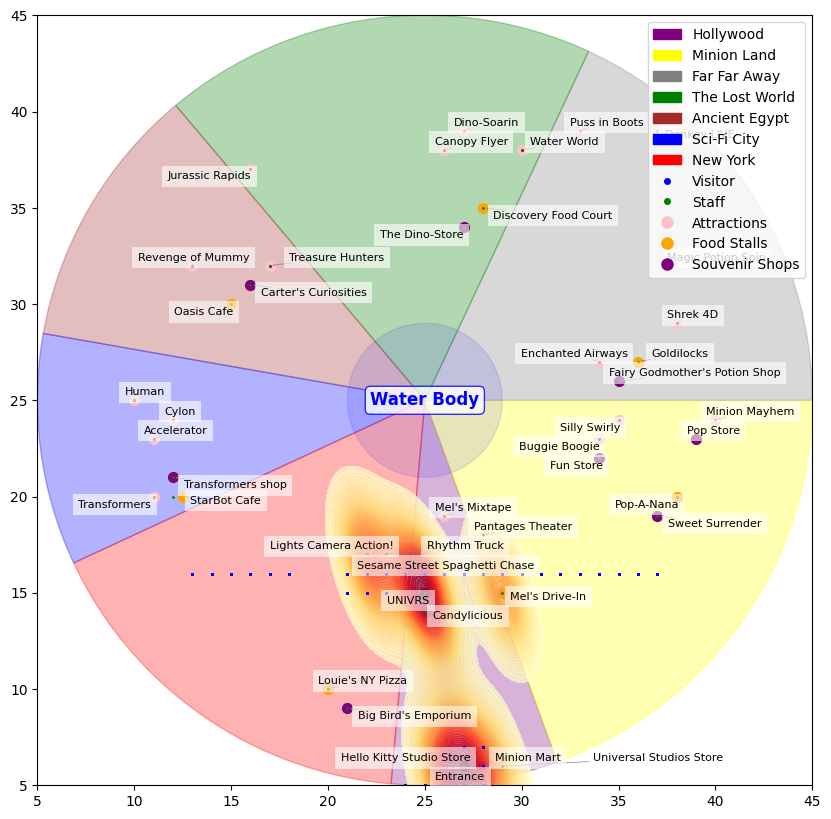

Time: 10:30 AM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 3
    Ride: Mel's Mixtape, Number of Staff: 3
    Ride: Entrance, Number of Staff: 4
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 3
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 3
    Ride: Puss in Boots, Number of Staff: 3
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 3
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 3
    Ride: Canopy Flyer, Number of Staff: 3
    Ride: Dino-Soarin, Number of Staff: 3
    Ride: Water World, Number of Staff: 3
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 3
    Ride: Treasure Hunters, Number of Staff: 3
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 3
    Ride: Cylon, Number 

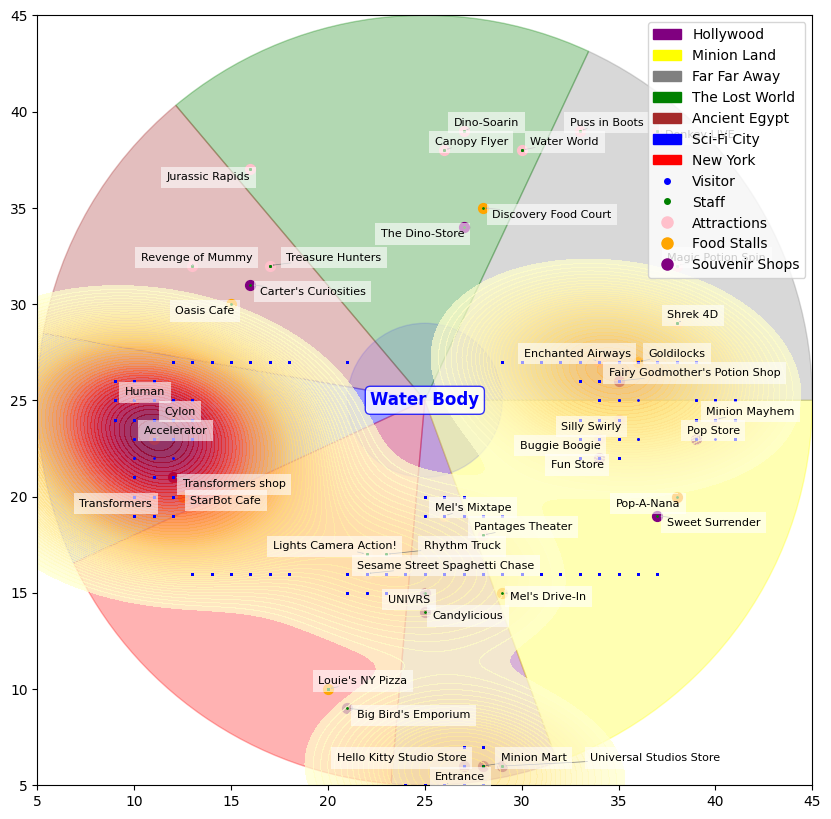

Time: 11:00 AM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 4
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 3
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 3
    Ride: Canopy Flyer, Number of Staff: 3
    Ride: Dino-Soarin, Number of Staff: 3
    Ride: Water World, Number of Staff: 3
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 3
    Ride: Treasure Hunters, Number of Staff: 3
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

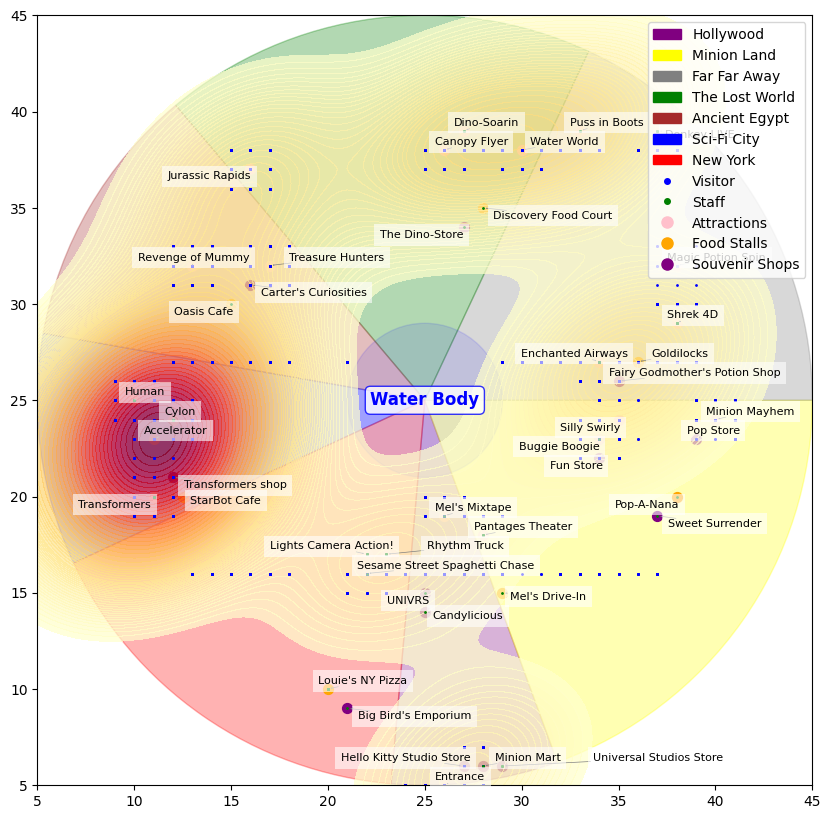

Time: 11:30 AM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 5
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 4
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

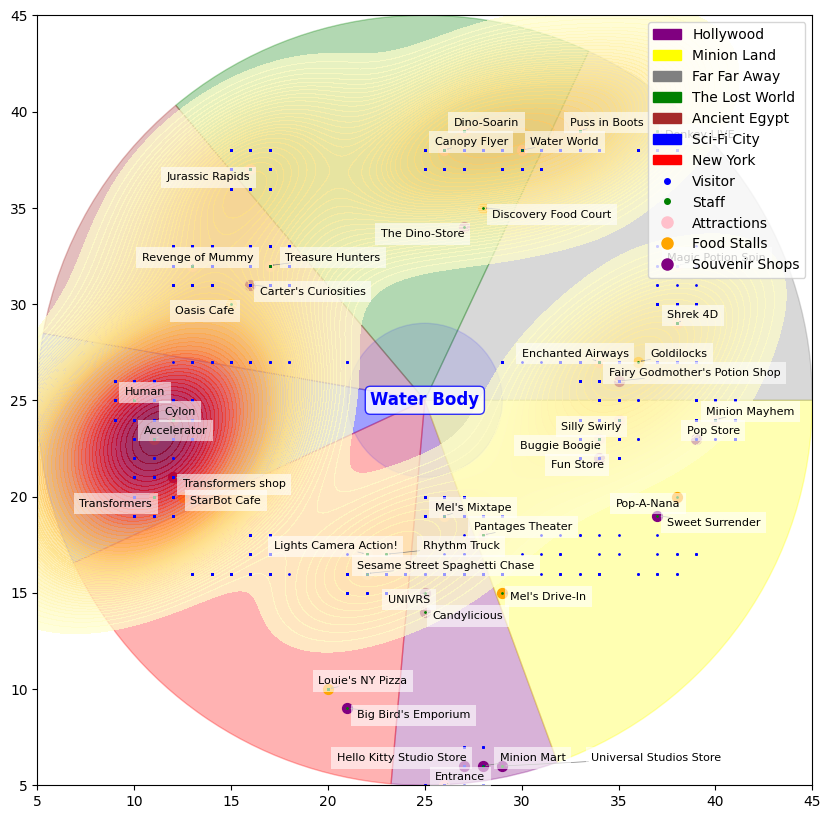

Time: 12:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 5
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 5
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 4
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 4
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

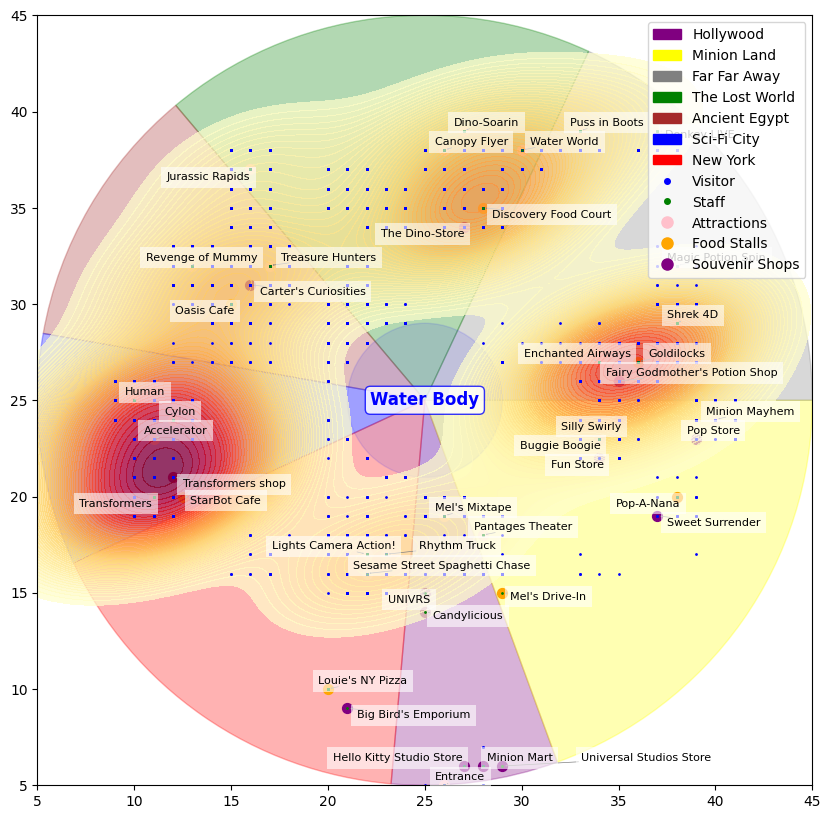

Time: 12:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 3
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 5
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 3
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

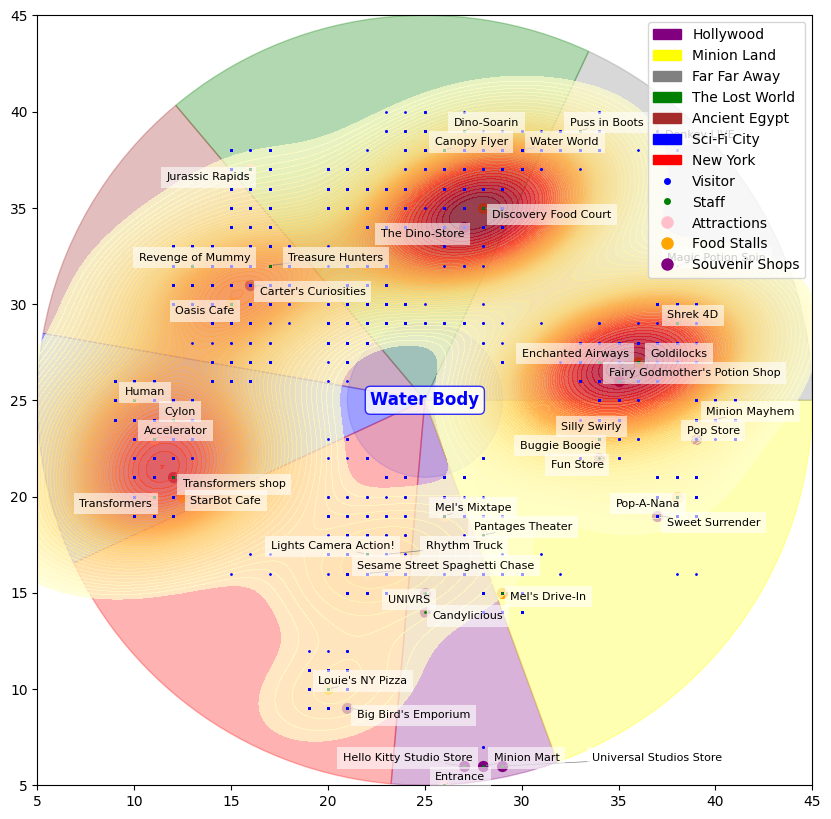

Time: 01:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 4
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 4
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

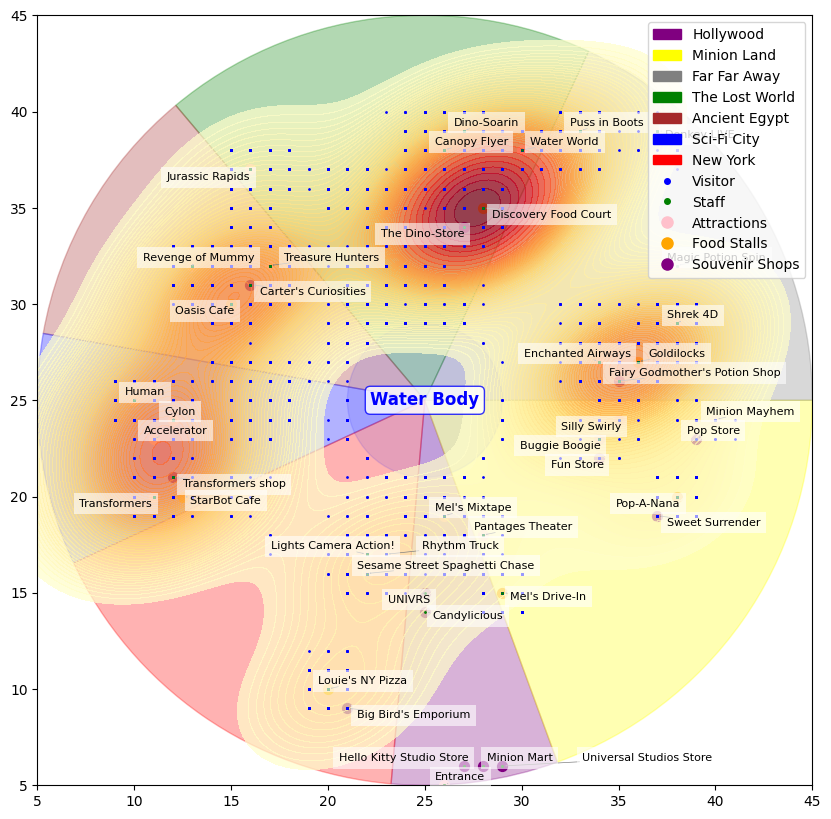

Time: 01:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 3
    Ride: Mel's Mixtape, Number of Staff: 3
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 5
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 3
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

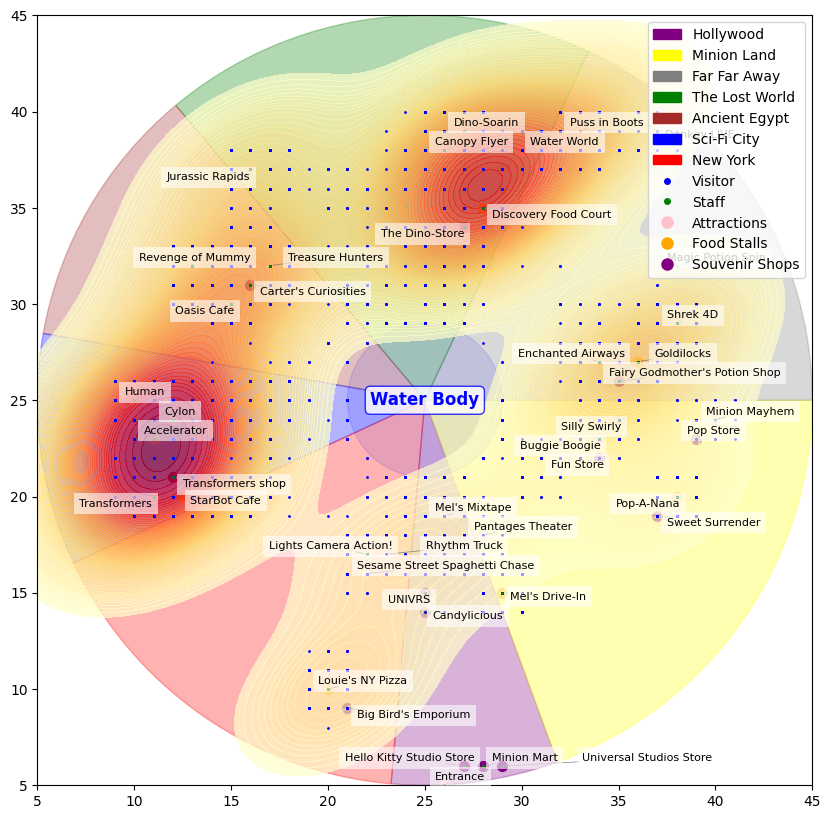

Time: 02:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 5
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 4
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

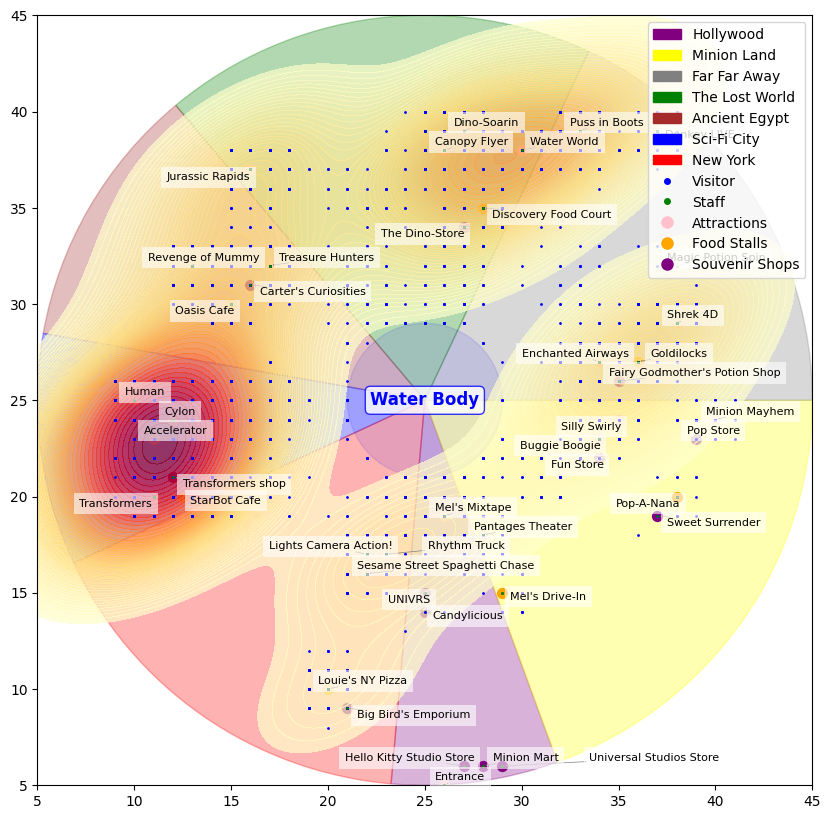

Time: 02:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 4
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 4
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

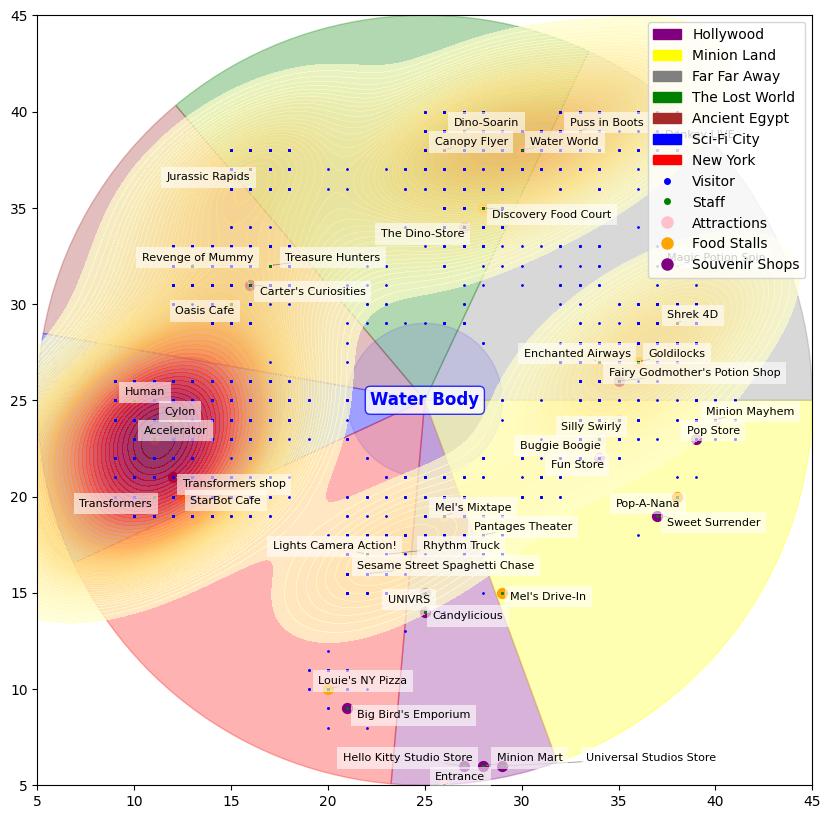

Time: 03:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 5
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

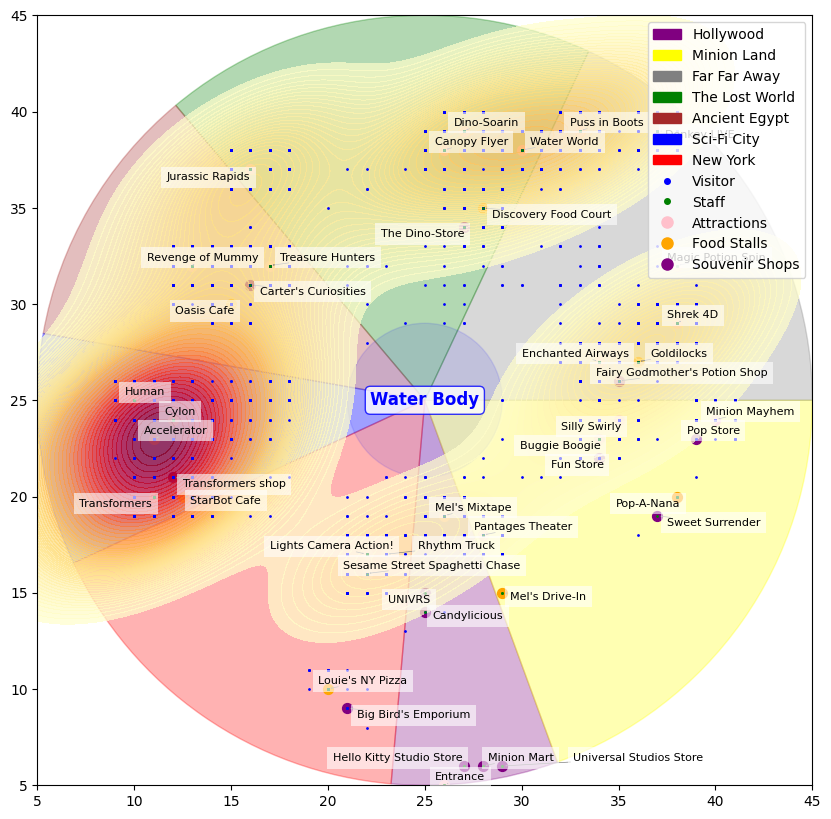

Time: 03:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

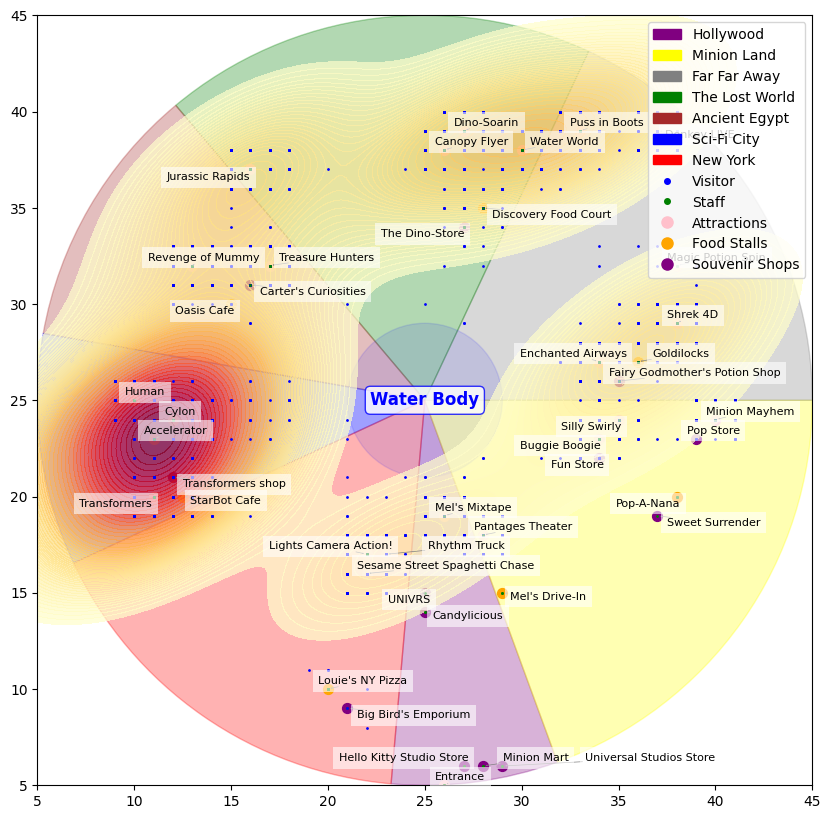

Time: 04:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

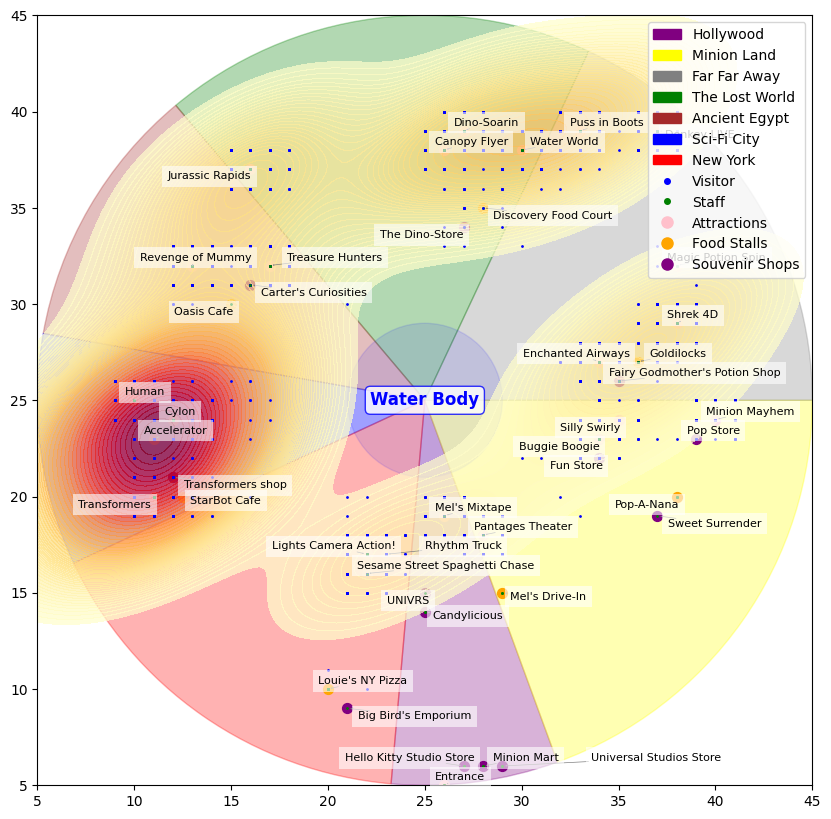

Time: 04:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

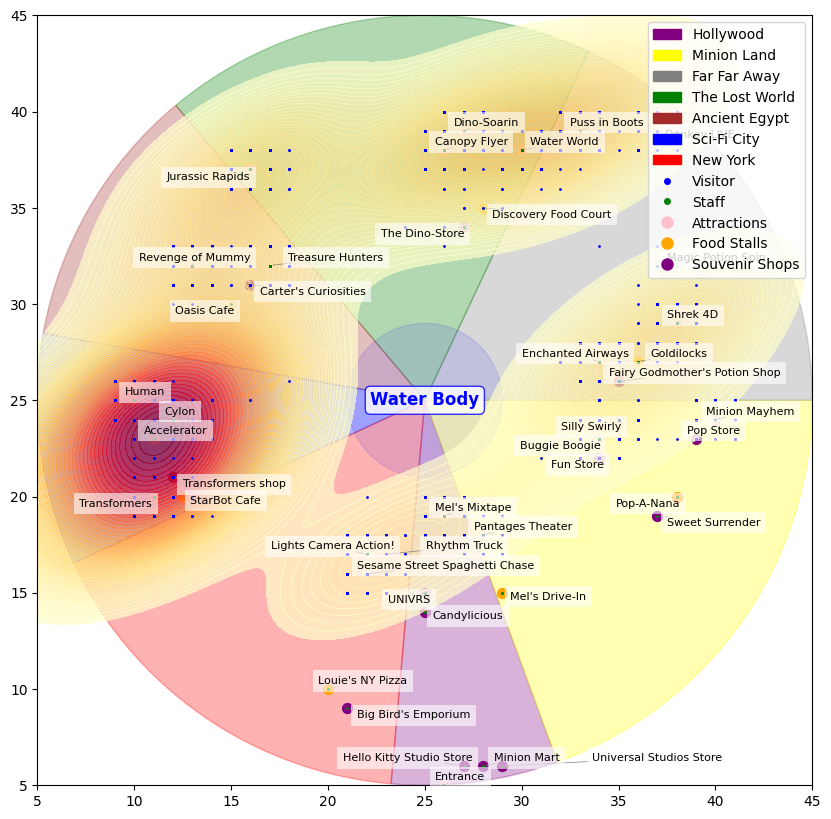

Time: 05:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

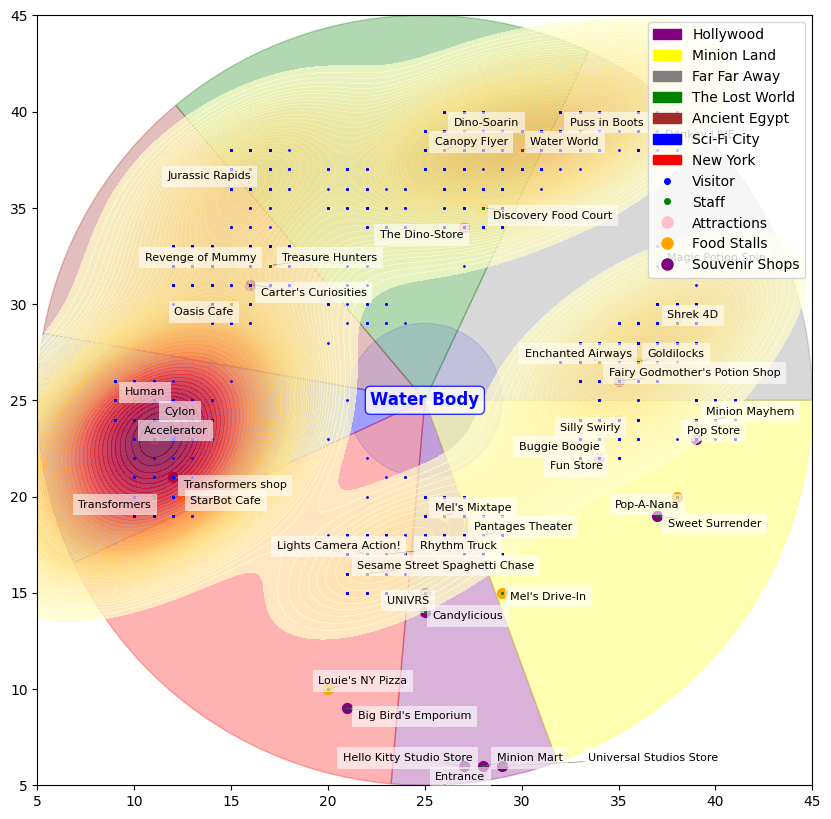

Time: 05:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 4
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

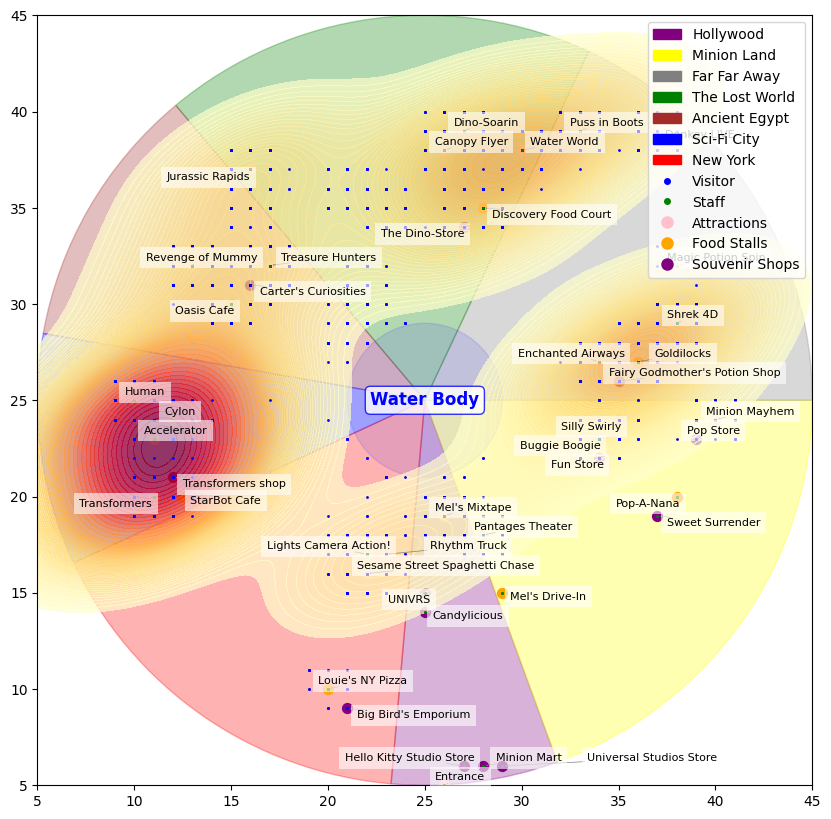

Time: 06:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 5
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

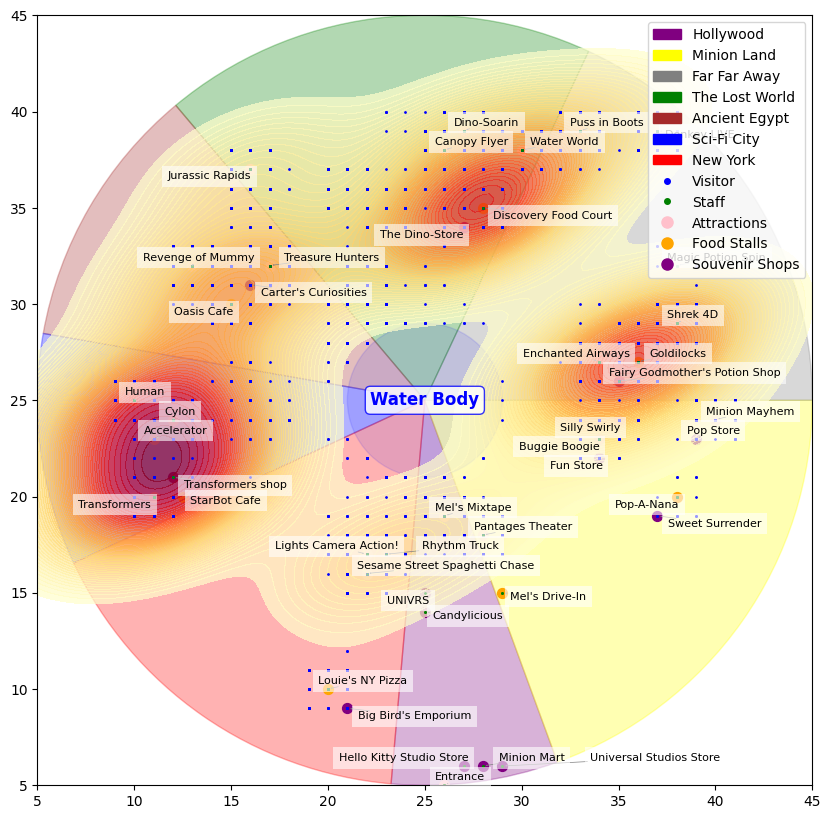

Time: 06:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 5
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

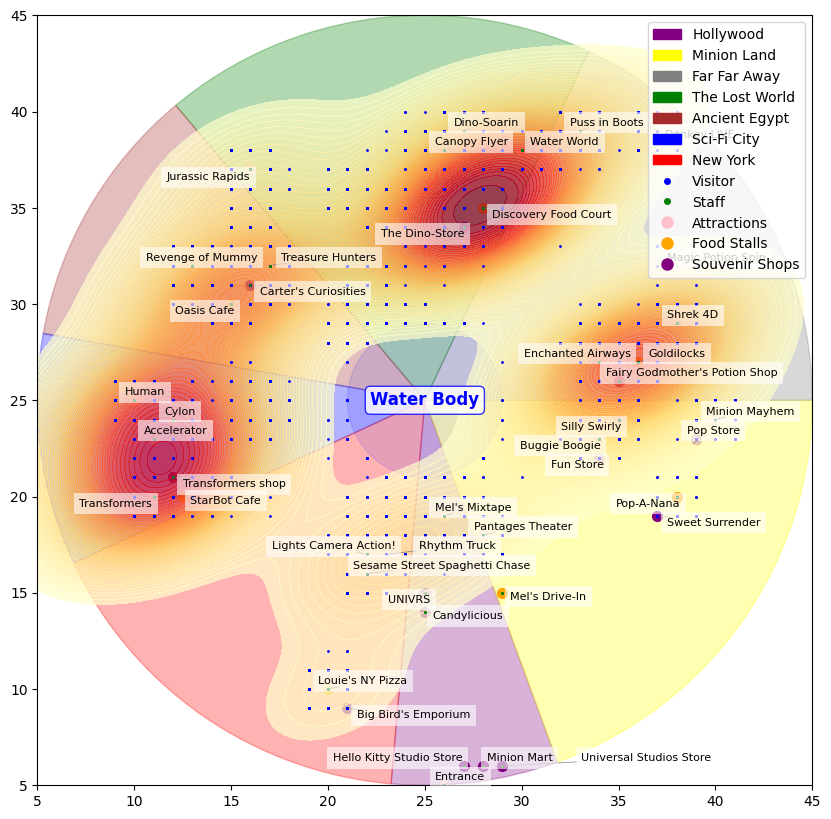

Time: 07:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 5
    Ride: Entrance, Number of Staff: 2
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

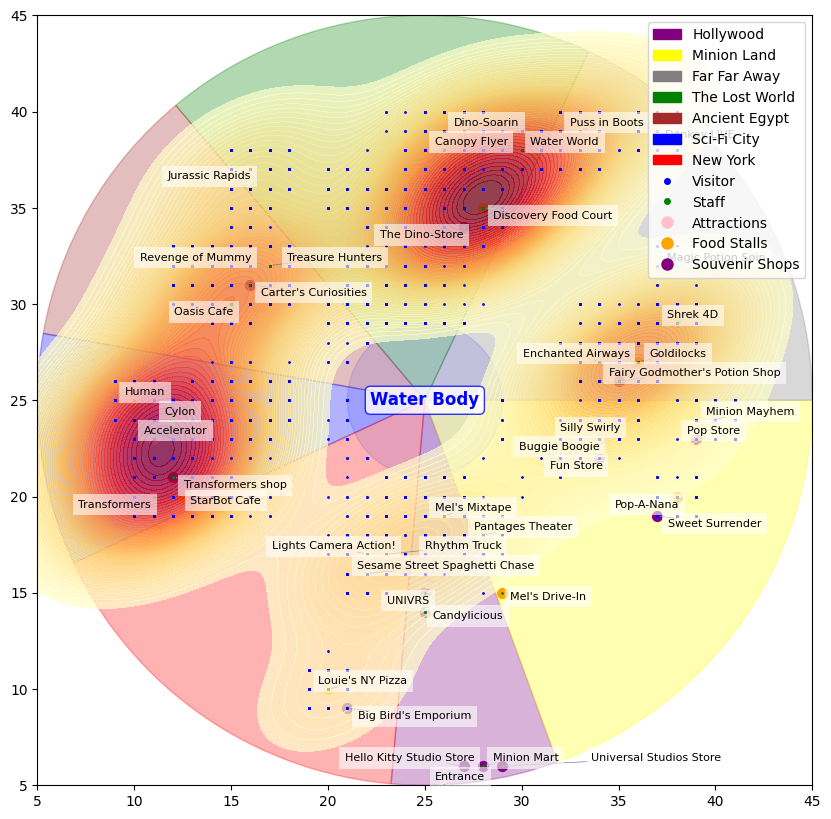

Time: 07:30 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 5
    Ride: Mel's Mixtape, Number of Staff: 5
    Ride: Entrance, Number of Staff: 4
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 4
    Ride: Silly Swirly, Number of Staff: 4
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 4
    Ride: Magic Potion Spin, Number of Staff: 4
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

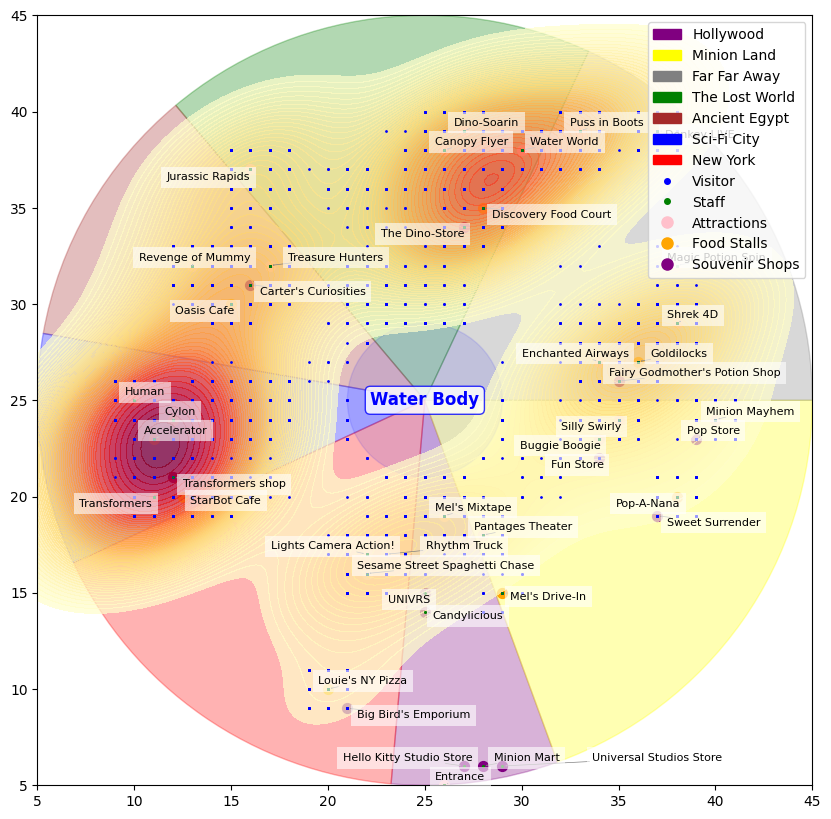

Time: 08:00 PM

Ride operating staff at each ride per zone:
  Zone: Hollywood
    Ride: Pantages Theater, Number of Staff: 4
    Ride: Mel's Mixtape, Number of Staff: 4
    Ride: Entrance, Number of Staff: 4
  Zone: Minion Land
    Ride: Minion Mayhem, Number of Staff: 3
    Ride: Silly Swirly, Number of Staff: 3
    Ride: Buggie Boogie, Number of Staff: 6
  Zone: Far Far Away
    Ride: Shrek 4D, Number of Staff: 6
    Ride: Puss in Boots, Number of Staff: 6
    Ride: Donkey LIVE, Number of Staff: 3
    Ride: Magic Potion Spin, Number of Staff: 3
    Ride: Enchanted Airways, Number of Staff: 6
  Zone: The Lost World
    Ride: Jurassic Rapids, Number of Staff: 6
    Ride: Canopy Flyer, Number of Staff: 6
    Ride: Dino-Soarin, Number of Staff: 6
    Ride: Water World, Number of Staff: 6
  Zone: Ancient Egypt
    Ride: Revenge of Mummy, Number of Staff: 6
    Ride: Treasure Hunters, Number of Staff: 6
  Zone: Sci-Fi City
    Ride: Transformers, Number of Staff: 6
    Ride: Cylon, Number 

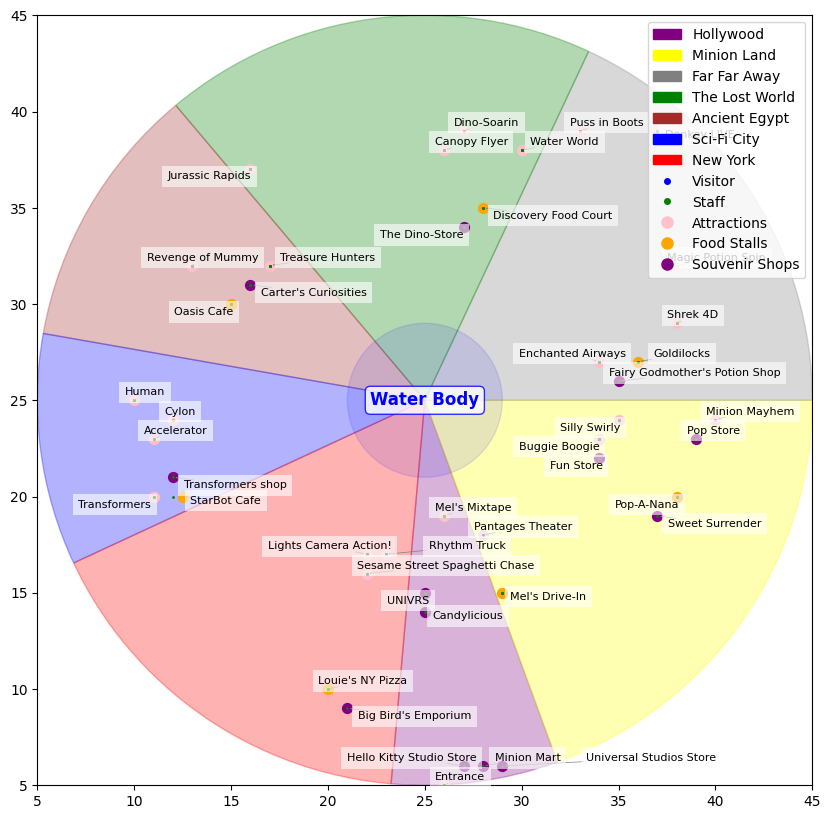

In [ ]:
def plot_theme_park(model, step):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(5, 45)
    ax.set_ylim(5, 45)

    # Plot USS Zones
    legend_patches = []
    for zone, data in uss_zones.items():
        wedge = Wedge(PARK_CENTER, PARK_RADIUS, *data["angle_range"], color=data["color"], alpha=0.3)
        ax.add_patch(wedge)
        legend_patches.append(mpatches.Patch(color=data["color"], label=zone))  # Add zone to legend

    # Plot central water body
    ax.add_patch(Circle(PARK_CENTER, WATER_RADIUS, color="blue", alpha=0.1))
    # Add label for the water body at the center
    ax.text(PARK_CENTER[0], PARK_CENTER[1], "Water Body",
        fontsize=12, color="blue", fontweight="bold",
        ha="center", va="center",
        bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3', alpha=0.8))

    texts = []
    # Plot Attractions, Food Stalls, and Souvenir Shops
    categories = [
        (attractions, 'pink', "Attractions"),
        (food_stalls, 'orange', "Food Stalls"),
        (souvenir_shops, 'purple', "Souvenir Shops")
    ]

    for category, color, label in categories:
        for points in category.values():
            for x, y, name in points:
                ax.scatter(x, y, color=color, s=50, label=label if label not in [p.get_label() for p in legend_patches] else "")
                text = ax.text(x, y, name, fontsize=8, ha="center", va="center",
                               bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                texts.append(text)
                # Count the number of visitors at each location
                count = sum(1 for agent in model.schedule.agents if isinstance(agent, Visitor) and agent.pos == (x, y))

    # Collect visitor positions at attractions
    heatmap_data = []

    for attraction_name, locations in attractions.items():
        for x, y, _ in locations:  # Extract x, y positions of attractions
            # Count visitors near the attraction
            nearby_visitors = [
                visitor for visitor in model.schedule.agents
                if isinstance(visitor, Visitor) and np.linalg.norm(np.array(visitor.pos) - np.array([x, y])) < 2
            ]
            if nearby_visitors:
                heatmap_data.append((x, y, len(nearby_visitors)))  # Store position and density

    for food_store_name, locations in food_stalls.items():
        for x, y, _ in locations:  # Extract x, y and ignore stall name
          # Count visitors near the food store
          nearby_visitors = [
              agent for agent in model.schedule.agents
              if isinstance(agent, Visitor) and abs(agent.pos[0] - x) <= 1 and abs(agent.pos[1] - y) <= 1
          ]
          if nearby_visitors:
                heatmap_data.append((x, y, len(nearby_visitors)))  # Store position and density

    for souvenir_store_name, locations in souvenir_shops.items():
        for x, y, _ in locations:  # Extract x, y positions of souvenir stores
            # Count visitors near the souvenir store
            nearby_visitors = [
                visitor for visitor in model.schedule.agents
                if isinstance(visitor, Visitor) and np.linalg.norm(np.array(visitor.pos) - np.array([x, y])) < 2
            ]
            if nearby_visitors:
                heatmap_data.append((x, y, len(nearby_visitors)))  # Store position and density

    # Process and plot the heatmap
    if heatmap_data:
        x_vals, y_vals, densities = zip(*heatmap_data)

        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        densities = np.array(densities)

        # KDE Plot
        sns.kdeplot(
          x=x_vals, y=y_vals, weights=densities,
          cmap="YlOrRd", fill=True, alpha=0.7,
          levels=60, bw_adjust=0.6, ax=ax
      )


    # Plot Agents (Visitors and Staff)
    for agent in model.schedule.agents:
        if isinstance(agent, Visitor):
            ax.scatter(*agent.pos, color='blue', s=1)  # Visitors
        elif isinstance(agent, Staff):
            ax.scatter(*agent.pos, color='green', s=1)  # Staff

    # Automatically adjust text positions to prevent overlap
    adjust_text(texts, expand=(1.2, 1.5), arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    # Create a circular legend marker for Visitors and Staff
    visitor_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label="Visitor")
    staff_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=4, label="Staff")

    # Add Visitors and Staff to the legend
    legend_patches.extend([visitor_marker, staff_marker])
    legend_patches.extend([
        mlines.Line2D([], [], color='pink', marker='o', linestyle='None', markersize=8, label="Attractions"),
        mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=8, label="Food Stalls"),
        mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=8, label="Souvenir Shops"),
    ])
    ax.legend(handles=legend_patches, loc='upper right', fontsize=10)

    plt.show()


park = ThemePark()
for s in range(TIME_STEPS):
    park.step()
    plot_theme_park(park, s)

With the insights from the ABM, we can better allocate staff throughout the day to the high traffic areas as adviced from the dynamic staff rostering generated and improve experience.

By deploying more staff to high-traffic areas, we can improve guest experience through faster service, enhance operational efficiency by preventing overcrowding and ensure better cleanliness and safety management with timely interventions.
